In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [4]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [5]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [9]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [10]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset_electricity = get_dataset("electricity_nips", regenerate=False)

In [11]:
dataset_electricity.metadata


MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [12]:
train_grouper_electricity = MultivariateGrouper(max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

test_grouper_electricity = MultivariateGrouper(num_test_dates=int(len(dataset_electricity.test)/len(dataset_electricity.train)), 
                                   max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

In [13]:
dataset_train_electricity = train_grouper_electricity(dataset_electricity.train)
dataset_test_electricity = test_grouper_electricity(dataset_electricity.test)


In [ ]:
estimator_electricity = TimeGradEstimator(
    input_size=int(dataset_electricity.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    num_inference_steps=149,
    prediction_length=dataset_electricity.metadata.prediction_length,
    context_length=dataset_electricity.metadata.prediction_length * 3,
    freq=dataset_electricity.metadata.freq,
    trainer_kwargs=dict(max_epochs=20, accelerator="gpu", devices="1"),
)


In [16]:
predictor_electricity = estimator_electricity.train(dataset_train_electricity, num_workers=8)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type          | Params | Mode  | In sizes                                                             | Out sizes        
-------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 432 K  | train | [[1, 1], [1, 1], [1, 72, 5], [1, 72, 370], [1, 72, 370], [1, 24, 5]] | [1, 100, 24, 370]
--------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.36768 (best 0.36768), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.10370 (best 0.10370), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.06144 (best 0.06144), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.05106 (best 0.05106), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_4/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.04672 (best 0.04672), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_4/checkpoints/epoch=4-step=250.ckpt' as top

In [17]:
forecast_it_electricity, ts_it_electricity = make_evaluation_predictions(dataset=dataset_test_electricity,
                                                 predictor=predictor_electricity,
                                                 num_samples=10)


In [18]:
forecasts_electricity = list(forecast_it_electricity)
targets_electricity = list(ts_it_electricity)

Electricity


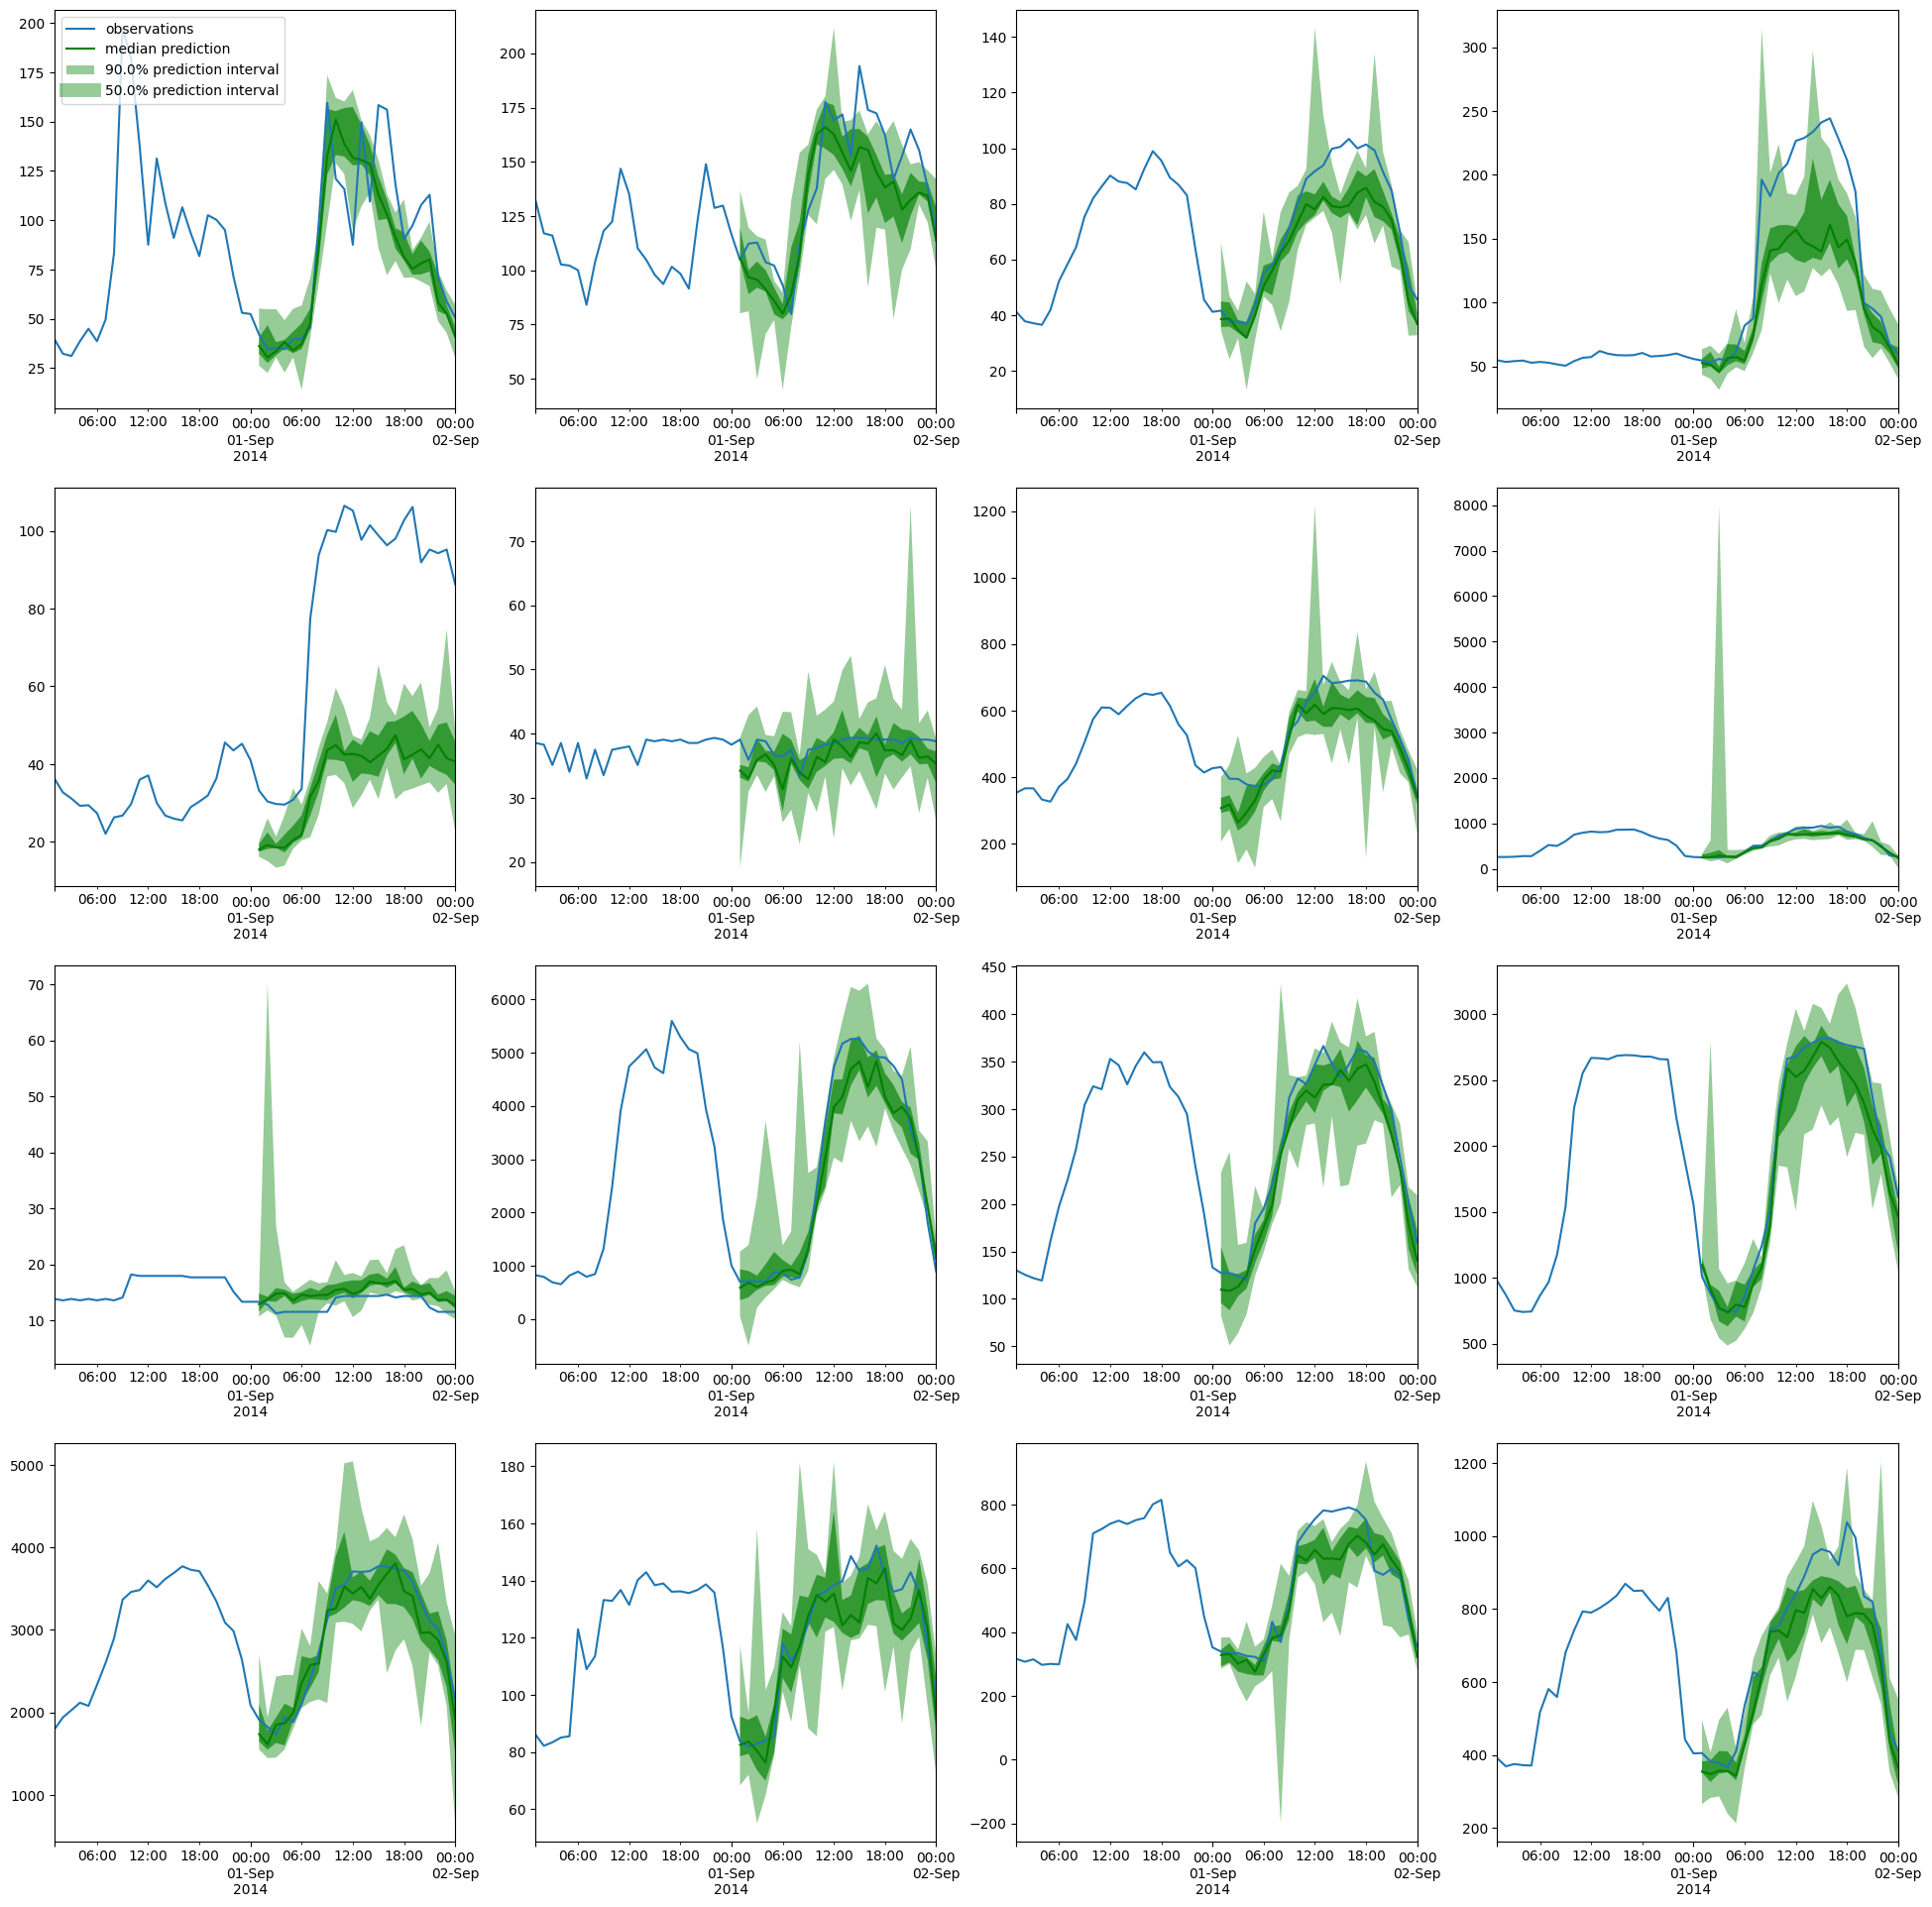

In [19]:
print("Electricity")

plot(
    target=targets_electricity[0],
    forecast=forecasts_electricity[0],
    prediction_length=dataset_electricity.metadata.prediction_length,
)
plt.show()

In [20]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [21]:
agg_metric_electricity, item_metrics_electricity = evaluator(targets_electricity, forecasts_electricity, num_series=len(dataset_test_electricity))


Running evaluation: 7it [00:00, 94.72it/s]
Running evaluation: 7it [00:00, 121.97it/s]
Running evaluation: 7it [00:00, 128.04it/s]
Running evaluation: 7it [00:00, 124.43it/s]
Running evaluation: 7it [00:00, 125.56it/s]
Running evaluation: 7it [00:00, 126.54it/s]
Running evaluation: 7it [00:00, 127.82it/s]
Running evaluation: 7it [00:00, 127.74it/s]
Running evaluation: 7it [00:00, 125.24it/s]
Running evaluation: 7it [00:00, 127.18it/s]
Running evaluation: 7it [00:00, 126.69it/s]
Running evaluation: 7it [00:00, 129.06it/s]
Running evaluation: 7it [00:00, 116.71it/s]
Running evaluation: 7it [00:00, 125.23it/s]
Running evaluation: 7it [00:00, 127.97it/s]
Running evaluation: 7it [00:00, 127.17it/s]
Running evaluation: 7it [00:00, 117.59it/s]
Running evaluation: 7it [00:00, 127.93it/s]
Running evaluation: 7it [00:00, 126.54it/s]
Running evaluation: 7it [00:00, 126.31it/s]
Running evaluation: 7it [00:00, 126.91it/s]
Running evaluation: 7it [00:00, 127.43it/s]
Running evaluation: 7it [00:00, 1

In [22]:
print("Electricity Results")
print("CRPS:", agg_metric_electricity["mean_wQuantileLoss"])
print("ND:", agg_metric_electricity["ND"])
print("NRMSE:", agg_metric_electricity["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_electricity["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_electricity["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_electricity["m_sum_NRMSE"])

Electricity Results
CRPS: 0.07341295439714754
ND: 0.0939845166946646
NRMSE: 0.8395509430151452

CRPS-Sum: 0.035954544197484145
ND-Sum: 0.04650167088412164
NRMSE-Sum: 0.06153391305333824
